In [1]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [2]:
# imports for langchain, plotly and Chroma

from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import plotly.graph_objects as go
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.embeddings import HuggingFaceEmbeddings


In [3]:
# price is a factor for our company, so we're going to use a low cost model

MODEL = "gpt-4o-mini"
db_name = "mrmvector_db"

## OpenAI() class and Key use: 
* openai = OpenAI()
* OPENAI_API_KEY must be named exactly that if you’re using OpenAI() without explicitly passing the key
* The OpenAI Python SDK (v1.x and later) is designed to automatically look for the environment variable: OPENAI_API_KEY.

## Alternative: 
* openai = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
* openai = OpenAI(api_key="sk-...")

* import os
* from openai import OpenAI

* my_key = os.getenv("MY_SECRET_KEY")
* client = OpenAI(api_key=my_key)








### What It Does:
It checks if OPENAI_API_KEY is already set in the environment.

If it is, it reassigns the same value back.

If it is not, it sets it to 'your-key-if-not-using-env'.

In [4]:
# Load environment variables in a file called .env
from dotenv import load_dotenv
load_dotenv(override=True)  # Load and override existing env vars if needed
# os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

True

In [5]:
# Example of using OpenAI class: 
from openai import OpenAI

api_key = os.getenv('OPENAI_API_KEY')

if not api_key:
    raise ValueError("OPENAI_API_KEY is not set")

client = OpenAI(api_key=api_key)  # ✅ use the variable, not a literal string

response = client.chat.completions.create(
    model=MODEL,  # or "gpt-4-turbo", "gpt-3.5-turbo", etc.
    messages=[
        {"role": "user", "content": "Hello!"}
    ]
)

print(response.choices[0].message.content)


Hello! How can I assist you today?


## 🧱 What Is a Document?
* In LangChain (and similar frameworks), a Document is typically a class like this:
* from langchain.schema import Document

* doc = Document(
*    page_content="This is the actual text content.",
*    metadata={"source": "file.pdf", "page": 1}
*)


In [6]:
import os
import glob
from langchain.document_loaders import PyPDFLoader
from langchain.schema import Document

root_path = "model_risk_management/*"  # adjust to your folder path
folders = glob.glob(root_path)  # find all folders under rootpath 
print("folders =>", folders)

documents = []
KEEP_METADATA_KEYS = ["source", "doc_type"]  # extend this as needed

for folder in folders:
    doc_type = os.path.basename(folder)   # base name of folders, served as doc_type
    print("doc_type =>", doc_type)

    # ** means “match any number of directories, this folder and subfolders, search match recursively”.
    # *.pdf matches all files ending with .pdf.
    pdf_paths = glob.glob(os.path.join(folder, "**/*.pdf"), recursive=True)
    # print("pdf_paths => ", pdf_paths)  # ['model_risk_management/self_prep/Stories.pdf']
    
    # This code loads PDF files, extracts their pages as documents, attaches useful metadata (like file path and type), 
    # and collects them into a list for further processing (e.g. chunking, vectorizing, etc.).
    for pdf_path in pdf_paths:
        loader = PyPDFLoader(pdf_path)  # create instance 
        pages = loader.load()  # load PDF, return a list of pages => Documments => one page of PDF

        # print("pages => ", pages[0:1])

        # page => Document object, an instance of LangChain Document class, has a structure
        
        for page in pages:
            page.metadata["source"] = pdf_path
            page.metadata["doc_type"] = doc_type
            
            # # Clean or standardize metadata
            # if "producer" in page.metadata:
            #     del page.metadata["producer"]
      
            # Retain only whitelisted metadata
            page.metadata = {
                key: value for key, value in page.metadata.items() if key in KEEP_METADATA_KEYS
            }
            documents.append(page)
            # print("page.metadata => , page.page_content =>" , page.metadata, page.page_content[:100])
          

print(f"Loaded {len(documents)} documents with metadata which has {len(page.metadata)} items in it.")

from pprint import pprint

print()
print("Text content:\n", documents[0].page_content[:500])  # first 500 characters
print("\nMetadata:")
pprint(documents[0].metadata)
print()



folders => ['model_risk_management/self_prep', 'model_risk_management/models', 'model_risk_management/regulatory_doc']
doc_type => self_prep
doc_type => models
doc_type => regulatory_doc
Loaded 55 documents with metadata which has 2 items in it.

Text content:
 Conversation  with  Matt  4/2:  ●  Next  steps:  2  rounds  of  interview  ○  Phone  interview:  1hr  ■  Interviewer:  one  from  a  pool  of  interviewers  (3  -  4)  ●  Matt  can  share  a  bit  more  on  the  interviewer  later  ■  5min,  warm  up,  background,  why  interested  in  Amazon  ■  Science  breath:  0.5hr   ●  ML  ●  High  level  overview  different  science  areas  ●  Compare   ●  Text  book  level  ●  What’s  on  my  resume  ●  Relevant  to  the  job  ●  When  to  use  what,  ho

Metadata:
{'doc_type': 'self_prep',
 'source': 'model_risk_management/self_prep/Stories.pdf'}



In [7]:
len(page.metadata)

2

In [8]:
type(documents), len(documents)

(list, 55)

In [9]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)
# Add metadata to start of content
# def attach_metadata(doc: Document):
#     meta = f"[source: {doc.metadata.get('source', '')}]\n[doc_type: {doc.metadata.get('doc_type', '')}]\n\n"
#     return Document(
#         page_content=meta + doc.page_content,
#         metadata=doc.metadata
#     )

# documents_with_metadata = [attach_metadata(doc) for doc in documents]
# chunks = text_splitter.split_documents(documents_with_metadata)

print(f"Generated {len(chunks)} chunks.")


Generated 229 chunks.


In [10]:
print(chunks[200])

page_content='deviation in expected versus actual performance and unexplained volatility in the profits 
and losses of trading activities may indicate that hedging and pricing relationships are not 
adequately measured by a given approach. Along with measuring the frequency of losses 
in excess of a single VaR percentile estimator, banks should use other tests, such as [Page Break]' metadata={'source': 'model_risk_management/regulatory_doc/sr1107a1.pdf', 'doc_type': 'regulatory_doc'}


In [13]:
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings


embeddings = OpenAIEmbeddings()

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

# vectorstore = Chroma.from_documents(chunks, OpenAIEmbeddings())
vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")


Vectorstore created with 229 documents


In [20]:
type(vectorstore)

langchain_community.vectorstores.chroma.Chroma

In [19]:
# Let's investigate the vectors

collection = vectorstore._collection
count = collection.count()

sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"There are {count:,} vectors with {dimensions:,} dimensions in the vector store")

There are 229 vectors with 1,536 dimensions in the vector store


## Set up a conversational RAG (Retrieval-Augmented Generation) pipeline using LangChain

🧠 What You're Building
You're combining:

A language model (llm)

A vector retriever (via Chroma)

A memory buffer for multi-turn conversations

To build a ConversationalRetrievalChain, which:

Retrieves relevant chunks from your documents using vector similarity, and then feeds both the question and relevant context to the LLM — plus past chat history.



In [16]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory

# llm = ChatOpenAI(temperature=0.7, model_name=MODEL)  # or "gpt-3.5-turbo"
# memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
# retriever = vectorstore.as_retriever()

# conversation_chain = ConversationalRetrievalChain.from_llm(
#     llm=llm,
#     retriever=retriever,
#     memory=memory
# )

# create a new Chat with OpenAI
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

# Alternative - if you'd like to use Ollama locally, uncomment this line instead
# llm = ChatOpenAI(temperature=0.7, model_name='llama3.2', base_url='http://localhost:11434/v1', api_key='ollama')

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG
retriever = vectorstore.as_retriever()

# putting it together: set up the conversation chain with the GPT 3.5 LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)



## ❓Do you need to define a system message in LangChain's ConversationalRetrievalChain?
No — it's not required.
If you don’t define a system message, LangChain uses a default system prompt that looks like:

"Use the following pieces of context to answer the user's question. If you don't know the answer, just say you don't know — don't try to make up an answer."

This default works reasonably well for general RAG use cases.

In [21]:
# question = "What are the customer obligations under this policy?"
# response = conversation_chain.run(question)
# print(response)


/var/folders/1r/m_0ldzk527lfywxxv30ykfzm0000gn/T/ipykernel_6128/3703484997.py:2: LangChainDeprecationWarning:

The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.



I don't know.


In [17]:
def chat(question, history):
    result = conversation_chain.invoke({"question": question})
    return result["answer"]

view = gr.ChatInterface(chat, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


/opt/anaconda3/envs/llms/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


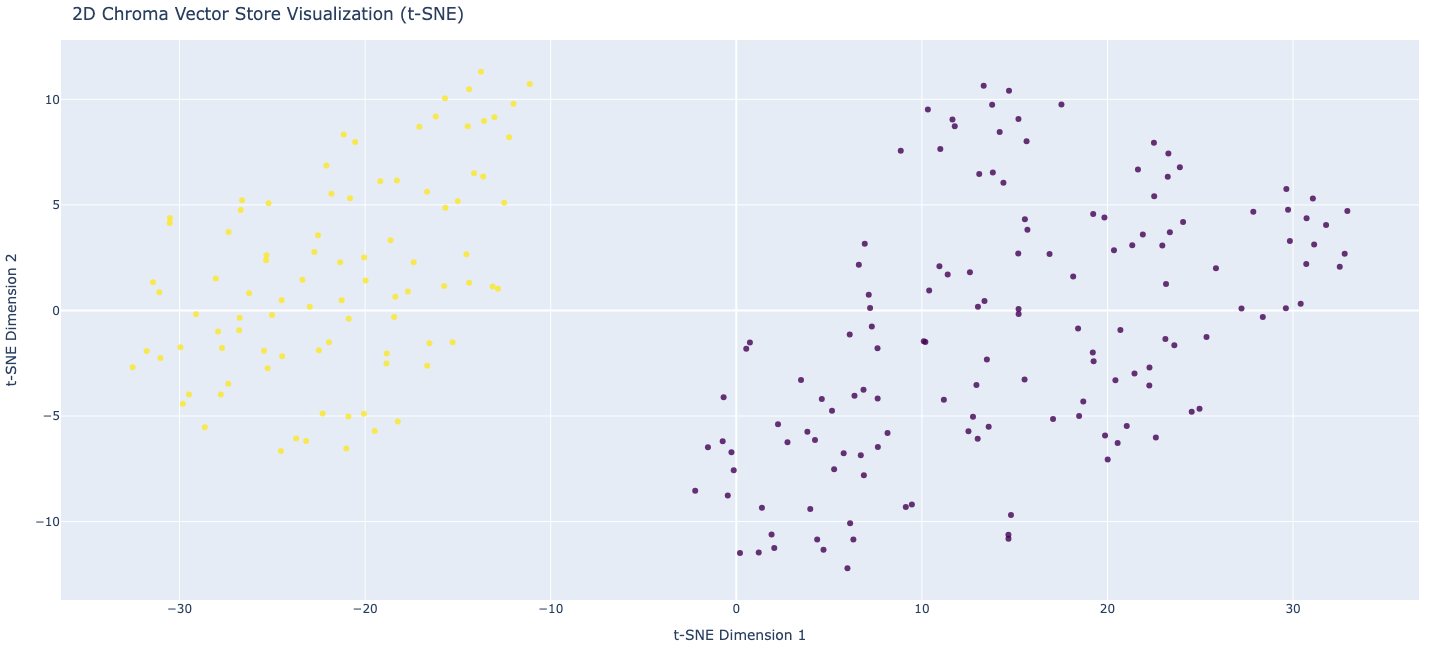

In [18]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from collections import defaultdict

# Fetch embeddings and metadata from Chroma
collection_data = vectorstore._collection.get(include=["embeddings", "metadatas", "documents"])

embeddings = collection_data["embeddings"]
metadatas = collection_data["metadatas"]
documents = collection_data["documents"]

# Use PDF file names as types/labels
# doc_types = [meta.get("source", "Unknown") for meta in metadatas]
doc_types = [meta.get("source", "Unknown") if meta else "Unknown" for meta in metadatas]


# Assign colors based on doc type
unique_types = list(set(doc_types))
color_map = {t: i for i, t in enumerate(unique_types)}
colors = [color_map[t] for t in doc_types]

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
reduced_vectors = tsne.fit_transform(embeddings)

# Build interactive plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=6, color=colors, opacity=0.8, colorscale='Viridis'),
    text=[f"File: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization (t-SNE)',
    xaxis_title='t-SNE Dimension 1',
    yaxis_title='t-SNE Dimension 2',
    width=900,
    height=650,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()